#### Imports

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import sys
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import glob
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

In [54]:
from sklearn.metrics import classification_report

#### Get Data

In [2]:
def import_images(folder,target):
    images = []
    for item in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,item),0)
        if img is not None:
            images.append([img,target])
    return images

In [3]:
# normal:0 , benign:1 , malignant:2
normal = import_images("/content/drive/MyDrive/senior_project/ult_data/normal",0)
benign = import_images("/content/drive/MyDrive/senior_project/ult_data/benign",1)
malignant = import_images("/content/drive/MyDrive/senior_project/ult_data/malignant",2)

#Value 0 appears 133 times.
#Value 1 appears 437 times.
#Value 2 appears 210 times.

In [101]:
import os

directory = '/content/drive/MyDrive/senior_project/ult_data/normal'

file_count = len(os.listdir(directory))

print(f"The number of data in the directory '{directory}' is: {file_count}")


The number of data in the directory '/content/drive/MyDrive/senior_project/ult_data/normal' is: 133


In [102]:
import os

directory = '/content/drive/MyDrive/senior_project/ult_data/benign'

file_count = len(os.listdir(directory))

print(f"The number of data in the directory '{directory}' is: {file_count}")


The number of data in the directory '/content/drive/MyDrive/senior_project/ult_data/benign' is: 437


# Visualize Data

In [4]:
def vis_images(image_class,image_num):
  # Assuming you have already selected the images you want to display and stored them in the "some_normal_images" list
  some_indices = np.random.randint(0, len(image_class), image_num)
  some_images = [image_class[i][0] for i in some_indices]
  num_images = len(some_images)

  # Calculate the number of rows and columns needed to display the images in a grid
  num_rows = (num_images - 1) // image_num + 1
  num_cols = min(num_images, image_num)

  # Create a grid of subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})

  # Resize each image to 256x256 pixels and plot it in a separate subplot
  for i, ax in enumerate(axes.flat):
      if i < num_images:
          img = cv2.resize(some_images[i], (256, 256))
          ax.imshow(img, cmap='gray')
          ax.set_title(f"Image {i+1} in class {image_class[0][1]}")
      ax.axis('off')

  # Show the plot
  plt.show()

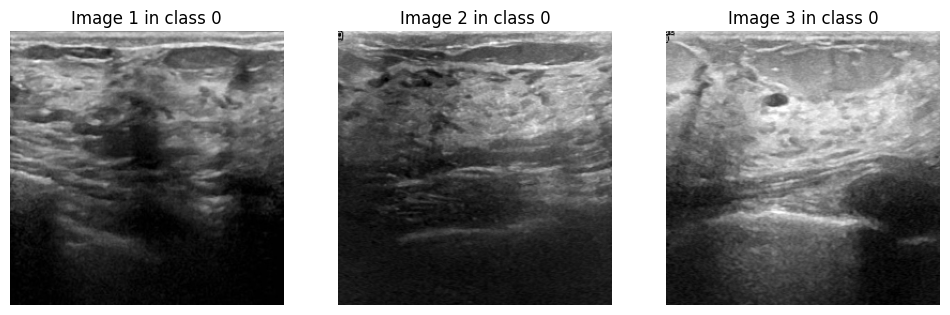

In [5]:
vis_images(normal,3)

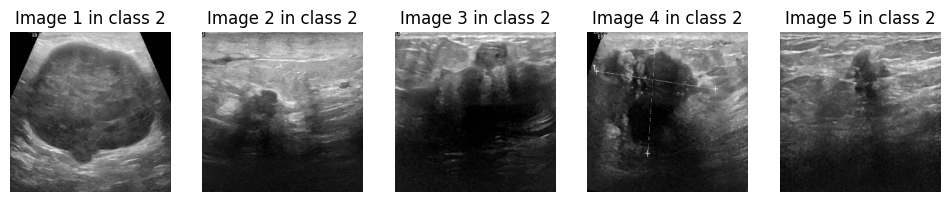

In [6]:
vis_images(malignant,5)

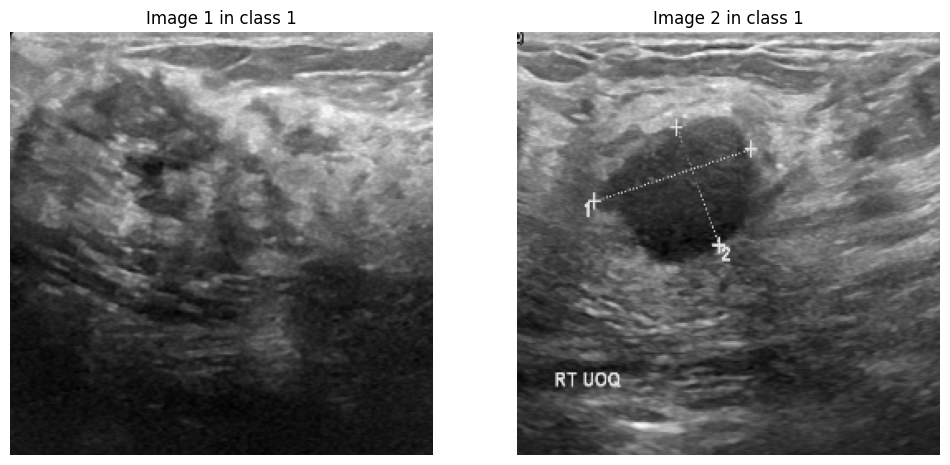

In [7]:
vis_images(benign,2)

# Create Dataset

In [8]:
data = normal

In [9]:
data[0]

[array([[  0,  43, 201, ..., 179, 174, 170],
        [  0,  44, 205, ..., 165, 159, 155],
        [  2,  39, 200, ..., 147, 143, 140],
        ...,
        [ 25,  25,  25, ...,  21,  24,  25],
        [ 23,  24,  25, ...,  24,  26,  27],
        [ 22,  22,  23, ...,  28,  29,  30]], dtype=uint8),
 0]

In [10]:
data.extend(malignant)
data.extend(benign)

In [11]:
len(data)

780

In [12]:
feature_matrix = []
label = []
for X,y in data:
    feature_matrix.append(X)
    label.append(y)

In [13]:
feature_matrix[0]

array([[  0,  43, 201, ..., 179, 174, 170],
       [  0,  44, 205, ..., 165, 159, 155],
       [  2,  39, 200, ..., 147, 143, 140],
       ...,
       [ 25,  25,  25, ...,  21,  24,  25],
       [ 23,  24,  25, ...,  24,  26,  27],
       [ 22,  22,  23, ...,  28,  29,  30]], dtype=uint8)

In [14]:
label[0]

0

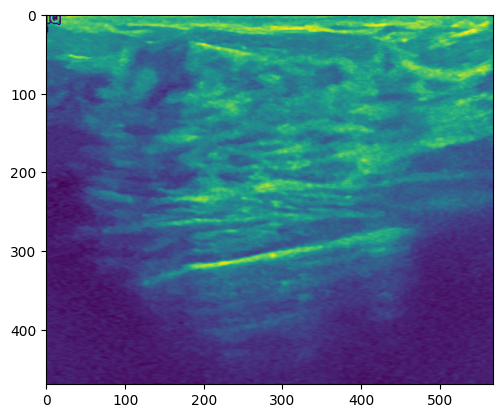

In [15]:
plt.imshow(feature_matrix[0])

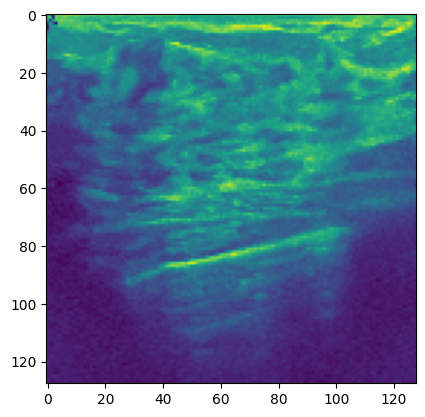

In [16]:
## resized image
X=[]
img_size=128

for x in feature_matrix:
    new_array = cv2.resize(x,(img_size,img_size))
    X.append(new_array)

plt.imshow(X[0])

# Normalize X

In [17]:
X_nor = []
for image in X:
    image = image/255
    X_nor.append(image)
X_nor[0]

array([[0.61960784, 0.38823529, 0.02352941, ..., 0.7372549 , 0.67843137,
        0.61568627],
       [0.61176471, 0.78431373, 0.00392157, ..., 0.74117647, 0.69411765,
        0.6627451 ],
       [0.60392157, 0.15294118, 0.58823529, ..., 0.70588235, 0.81568627,
        0.6745098 ],
       ...,
       [0.06666667, 0.08627451, 0.11372549, ..., 0.08235294, 0.08627451,
        0.09411765],
       [0.09019608, 0.09019608, 0.0745098 , ..., 0.09019608, 0.10196078,
        0.09019608],
       [0.09803922, 0.07058824, 0.05882353, ..., 0.08235294, 0.0627451 ,
        0.09411765]])

# Change the shape of X to prepare Deep Learning

In [18]:
np.array(X_nor).shape

(780, 128, 128)

In [19]:
X_nor = np.array(X_nor)

In [20]:
X = X_nor.reshape(X_nor.shape[0],X_nor.shape[1],X_nor.shape[2],1)

In [76]:
X.shape

(780, 128, 128, 1)

In [77]:
label = np.array(label)

In [78]:
label.shape

(780,)

# Split data as train, validation and test

In [79]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,label,test_size = 0.15,shuffle=True,random_state=42,stratify=label)


In [80]:
print("X_train size: ",X_train.shape)
print("X_test Size: ",X_test.shape)

X_train size:  (663, 128, 128, 1)
X_test Size:  (117, 128, 128, 1)


In [81]:
y_train.shape, y_test.shape

((663,), (117,))

In [82]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 3)
y_test = to_categorical(y_test, num_classes = 3)

In [83]:
y_train.shape, y_test.shape

((663, 3), (117, 3))

# Data Augmentation

In [84]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate the image by up to 20 degrees
    width_shift_range=0.1,  # Shift the image horizontally by up to 10%
    height_shift_range=0.1,  # Shift the image vertically by up to 10%
    horizontal_flip=True,  # Flip the image horizontally
    vertical_flip=True  # Flip the image vertically
)
datagen.fit(X_train)

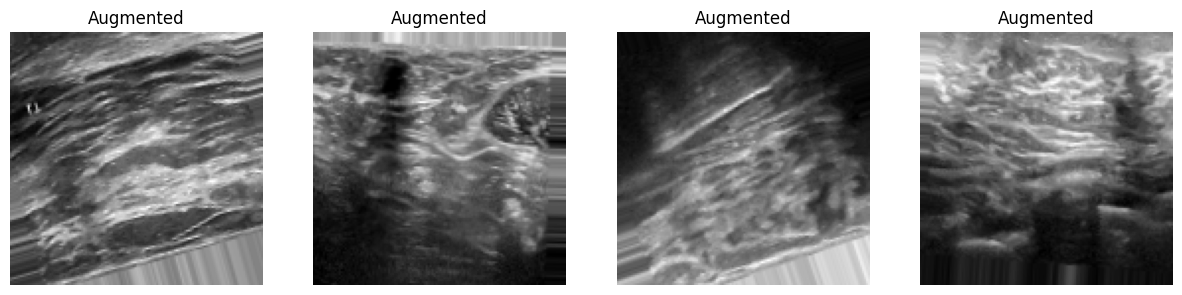

In [85]:
augmented_data = datagen.flow(X_train, y_train, batch_size=32)

# Display the first few augmented images
fig, axs = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    augmented_image = augmented_data.next()[0][0]
    axs[i].imshow(augmented_image.squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title('Augmented')

plt.show()


In [86]:
# Set the number of batches to generate
num_batches = int(np.ceil(len(X_train) / 32))

X_train_augmented, y_train_augmented = augmented_data.next()
for i in range(num_batches - 1):
    augmented_images, augmented_labels = augmented_data.next()
    X_train_augmented = np.concatenate([X_train_augmented, augmented_images])
    y_train_augmented = np.concatenate([y_train_augmented, augmented_labels])

# Print the shape of the augmented data and labels
print('X_train_augmented shape:', X_train_augmented.shape)
print('y_train_augmented shape:', y_train_augmented.shape)


X_train_augmented shape: (663, 128, 128, 1)
y_train_augmented shape: (663, 3)


In [87]:
X_train_final = np.concatenate([X_train, X_train_augmented])
y_train_final = np.concatenate([y_train, y_train_augmented])

In [88]:
X_train_final.shape

(1326, 128, 128, 1)

In [89]:
y_train_final.shape

(1326, 3)

# Models

## Model 1 CNN

#### Model Architecture

In [ ]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128,1)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(3, activation='softmax')
])


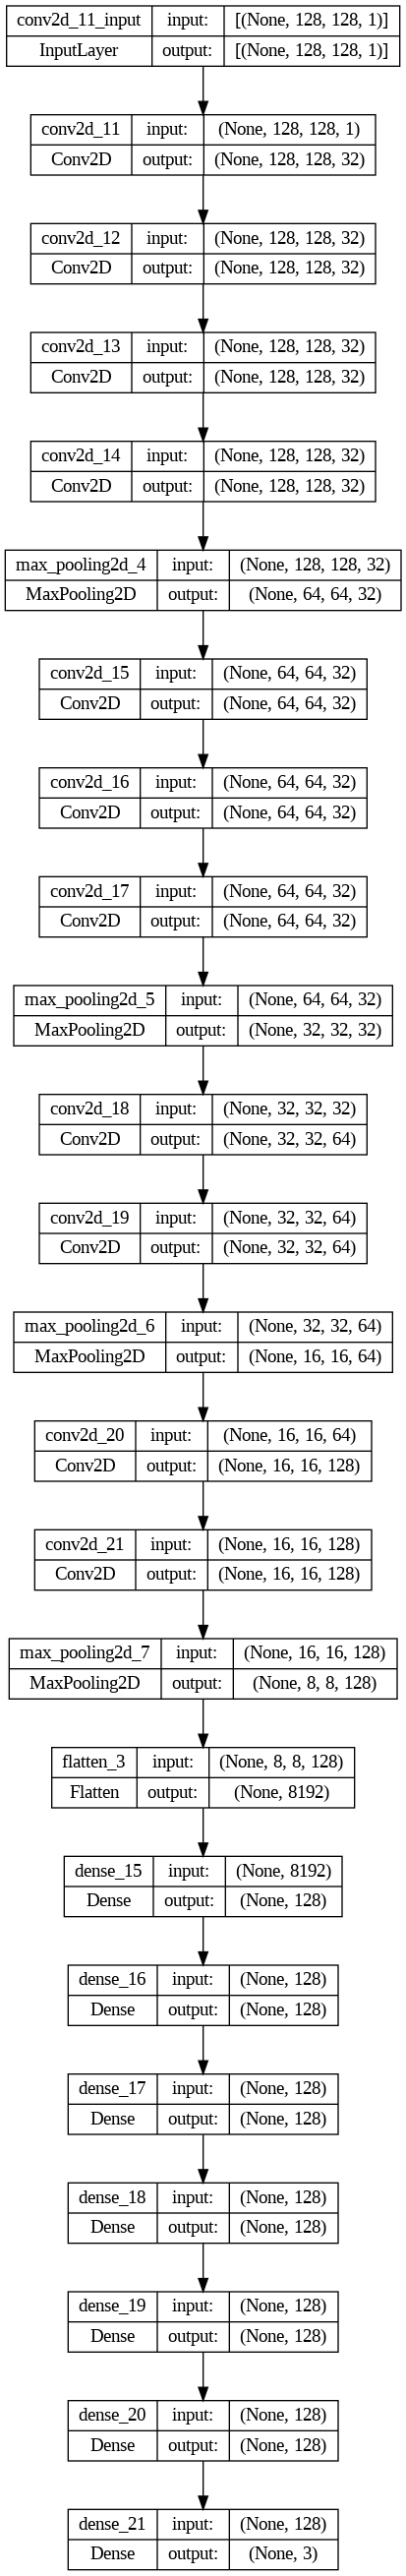

In [ ]:
from keras.utils import plot_model
plot_model(model_1, to_file='model_1_ult.png', show_shapes=True)

### Original Data

#### Compile

In [ ]:
opt = Adam(lr=0.001)
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### Fit

In [ ]:
history_1_or = model_1.fit(X_train,y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
21/21 [==============================] - 11s 134ms/step - loss: 1.0725 - accuracy: 0.5143 - val_loss: 0.9697 - val_accuracy: 0.5726
Epoch 2/10
21/21 [==============================] - 1s 55ms/step - loss: 0.9652 - accuracy: 0.5581 - val_loss: 0.9334 - val_accuracy: 0.5726
Epoch 3/10
21/21 [==============================] - 1s 55ms/step - loss: 0.9327 - accuracy: 0.5807 - val_loss: 0.8315 - val_accuracy: 0.6325
Epoch 4/10
21/21 [==============================] - 1s 55ms/step - loss: 0.9371 - accuracy: 0.6003 - val_loss: 0.9163 - val_accuracy: 0.6068
Epoch 5/10
21/21 [==============================] - 1s 55ms/step - loss: 0.9334 - accuracy: 0.6078 - val_loss: 0.9824 - val_accuracy: 0.6068
Epoch 6/10
21/21 [==============================] - 1s 54ms/step - loss: 0.9190 - accuracy: 0.6003 - val_loss: 0.8544 - val_accuracy: 0.5812
Epoch 7/10
21/21 [==============================] - 1s 54ms/step - loss: 0.8323 - accuracy: 0.6440 - val_loss: 0.8341 - val_accuracy: 0.6068
Epoch 8/10


#### Evaluate

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 [==============================] - 0s 19ms/step - loss: 0.6997 - accuracy: 0.7094
Test Loss: 0.6996801495552063
Test Accuracy: 0.7094017267227173


#### Visualize the results

In [ ]:
#plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate lass curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))# how many epochs did we run for?

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("model loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("model accuracy")
  plt.xlabel("epochs")
  plt.legend()

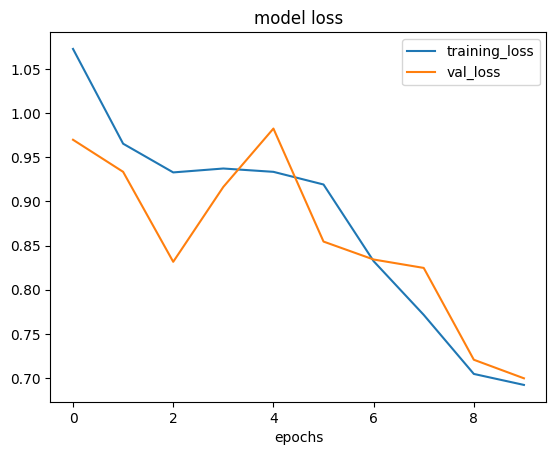

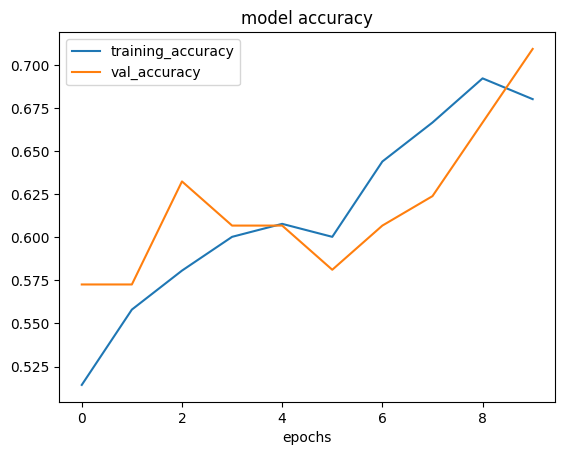

In [ ]:
plot_loss_curves(history_1_or)

#### Predictions

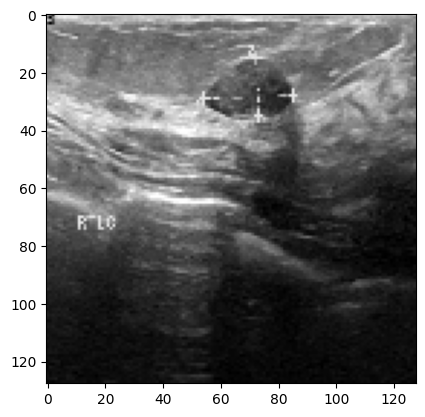

In [ ]:
plt.imshow(X_test[100])

In [ ]:
y_test[100]

array([0., 1., 0.], dtype=float32)

In [ ]:
X_test[100]

array([[[0.70196078, 0.70196078, 0.70196078],
        [0.55686275, 0.55686275, 0.55686275],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.67058824, 0.67058824, 0.67058824],
        [0.64705882, 0.64705882, 0.64705882],
        [0.77647059, 0.77647059, 0.77647059]],

       [[0.45882353, 0.45882353, 0.45882353],
        [0.        , 0.        , 0.        ],
        [0.50196078, 0.50196078, 0.50196078],
        ...,
        [0.63921569, 0.63921569, 0.63921569],
        [0.58823529, 0.58823529, 0.58823529],
        [0.51764706, 0.51764706, 0.51764706]],

       [[0.76862745, 0.76862745, 0.76862745],
        [0.6627451 , 0.6627451 , 0.6627451 ],
        [0.29019608, 0.29019608, 0.29019608],
        ...,
        [0.52941176, 0.52941176, 0.52941176],
        [0.53333333, 0.53333333, 0.53333333],
        [0.58431373, 0.58431373, 0.58431373]],

       ...,

       [[0.0745098 , 0.0745098 , 0.0745098 ],
        [0.03921569, 0.03921569, 0.03921569],
        [0.06666667, 0

In [ ]:
# Assuming X_test is your preprocessed test data
predictions = model_1.predict(X_test)

# Assuming your model predicts probabilities for multiple classes
# You can extract the predicted class for the first sample
predicted_class = np.argmax(predictions[100])

print("Predicted class:", predicted_class)


4/4 [==============================] - 0s 18ms/step
Predicted class: 1


In [ ]:
y_test[20]

array([1., 0., 0.], dtype=float32)

In [ ]:
predictions[20]

array([0.26083815, 0.5453837 , 0.19377819], dtype=float32)

#### Save model

In [ ]:
model_1.save('/content/drive/MyDrive/senior_project/models/ult_model_1_final.hdf5')

In [94]:
model = load_model('/content/drive/MyDrive/senior_project/models/ult_model_1_final.hdf5')
# Assuming your predicted labels are stored in y_pred and true labels are stored in y_test
# Convert the predicted and true labels into class indices (0, 1, 2)
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_indices, y_pred_indices)
print(report)

4/4 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.70      0.35      0.47        20
           1       0.79      0.92      0.85        66
           2       0.67      0.65      0.66        31

    accuracy                           0.75       117
   macro avg       0.72      0.64      0.66       117
weighted avg       0.74      0.75      0.73       117



In [95]:
y_pred_indices

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1,
       2, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1])

### Augmented Data

#### Fit

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),ModelCheckpoint('model_1_aug.hdf5',save_best_only=True)]

In [ ]:
history_1_aug = model_1.fit(X_train_final,y_train_final, epochs=20,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/20
42/42 [==============================] - 3s 59ms/step - loss: 0.0781 - accuracy: 0.9744 - val_loss: 1.5722 - val_accuracy: 0.7863
Epoch 2/20
42/42 [==============================] - 2s 56ms/step - loss: 0.1041 - accuracy: 0.9759 - val_loss: 1.0485 - val_accuracy: 0.7949
Epoch 3/20
42/42 [==============================] - 2s 53ms/step - loss: 0.0302 - accuracy: 0.9894 - val_loss: 1.2588 - val_accuracy: 0.7949
Epoch 4/20
42/42 [==============================] - 2s 54ms/step - loss: 0.0286 - accuracy: 0.9887 - val_loss: 1.1515 - val_accuracy: 0.8462
Epoch 5/20
42/42 [==============================] - 2s 54ms/step - loss: 0.0106 - accuracy: 0.9962 - val_loss: 1.3144 - val_accuracy: 0.8034
Epoch 6/20
42/42 [==============================] - 2s 55ms/step - loss: 0.0114 - accuracy: 0.9955 - val_loss: 1.4618 - val_accuracy: 0.7949
Epoch 7/20
42/42 [==============================] - 2s 57ms/step - loss: 0.0186 - accuracy: 0.9962 - val_loss: 1.0458 - val_accuracy: 0.8291
Epoch 8/20
42

#### Evaluate

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 [==============================] - 0s 19ms/step - loss: 1.8226 - accuracy: 0.7949
Test Loss: 1.8225915431976318
Test Accuracy: 0.7948718070983887


#### Visualize the results

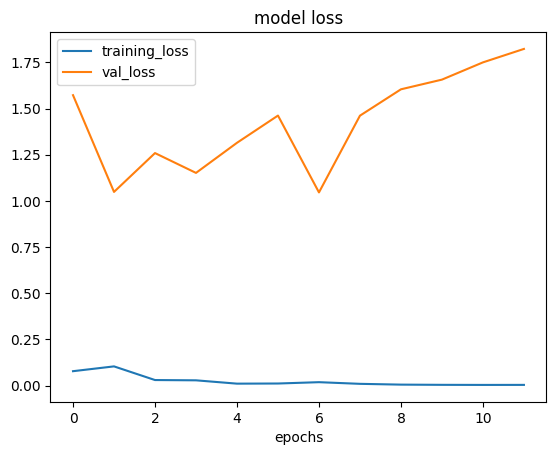

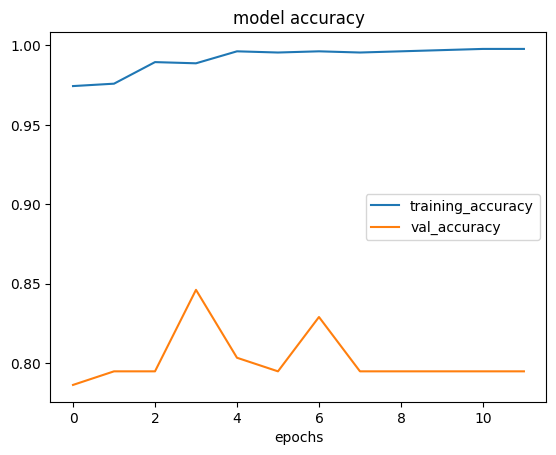

In [ ]:
plot_loss_curves(history_1_aug)

#### Predictions

In [ ]:
# Assuming X_test is your preprocessed test data
predictions = model_1.predict(X_test)

# Assuming your model predicts probabilities for multiple classes
# You can extract the predicted class for the first sample
predicted_class = np.argmax(predictions[100])

print("Predicted class:", predicted_class)

4/4 [==============================] - 0s 17ms/step
Predicted class: 1


In [ ]:
X_test[100]

array([[[0.70196078],
        [0.55686275],
        [0.04313725],
        ...,
        [0.67058824],
        [0.64705882],
        [0.77647059]],

       [[0.45882353],
        [0.        ],
        [0.50196078],
        ...,
        [0.63921569],
        [0.58823529],
        [0.51764706]],

       [[0.76862745],
        [0.6627451 ],
        [0.29019608],
        ...,
        [0.52941176],
        [0.53333333],
        [0.58431373]],

       ...,

       [[0.0745098 ],
        [0.03921569],
        [0.06666667],
        ...,
        [0.06666667],
        [0.05490196],
        [0.04313725]],

       [[0.06666667],
        [0.07843137],
        [0.08627451],
        ...,
        [0.01960784],
        [0.03529412],
        [0.03921569]],

       [[0.01960784],
        [0.02745098],
        [0.01960784],
        ...,
        [0.04313725],
        [0.02352941],
        [0.01176471]]])

In [ ]:
y_test[100]

array([0., 1., 0.], dtype=float32)

In [ ]:
np.argmax(predictions[20])

0

In [ ]:
y_test[20]

array([1., 0., 0.], dtype=float32)

#### Save model

In [ ]:
model_1.save('/content/drive/MyDrive/senior_project/models/ult_final_model_1_aug.hdf5')

In [91]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/senior_project/models/ult_final_model_1_aug.hdf5')

In [93]:
X_test.shape

(117, 128, 128, 1)

In [92]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming your predicted labels are stored in y_pred and true labels are stored in y_test
# Convert the predicted and true labels into class indices (0, 1, 2)
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_indices, y_pred_indices)
print(report)

4/4 [==============================] - 7s 64ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.97      0.98      0.98        66
           2       0.97      0.94      0.95        31

    accuracy                           0.97       117
   macro avg       0.96      0.96      0.96       117
weighted avg       0.97      0.97      0.97       117



## Model 2: SVM Model

In [34]:
X.shape

(780, 128, 128, 1)

In [35]:
X_nor.shape

(780, 128, 128)

In [42]:
# Assuming X represents your input data with shape (780, 128, 128, 1)

n_samples = X.shape[0]
image_height = X.shape[1]
image_width = X.shape[2]

# Flatten the images
X_flattened = X.reshape(n_samples, image_height * image_width)
X_flattened.shape

(780, 16384)

In [43]:
label.shape

(780,)

In [47]:
from sklearn.preprocessing import LabelEncoder

# Assuming y represents your original labels with shape (780,)

# Perform label encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(label)

# Verify the new shape
print(y_encoded.shape)  # (780,)


(780,)


In [98]:
np.unique(y_encoded)

array([0, 1, 2])

In [99]:
unique_values, value_counts = np.unique(y_encoded, return_counts=True)

for value, count in zip(unique_values, value_counts):
    print(f"Value {value} appears {count} times.")

Value 0 appears 133 times.
Value 1 appears 437 times.
Value 2 appears 210 times.


In [52]:
import os
import numpy as np
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded,shuffle=True)

# Create an SVM classifier
clf = svm.SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6730769230769231


In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.07      0.14        27
           1       0.64      0.95      0.76        87
           2       0.83      0.48      0.61        42

    accuracy                           0.67       156
   macro avg       0.82      0.50      0.50       156
weighted avg       0.75      0.67      0.61       156



In [59]:
pip install joblib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
from sklearn.svm import SVC
import joblib
# Save the model to a file
joblib.dump(clf, 'ult_svm_model_1.pkl')

['ult_svm_model_1.pkl']

## SVM with Augmented Data

In [63]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded,shuffle=True)


In [64]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate the image by up to 20 degrees
    width_shift_range=0.1,  # Shift the image horizontally by up to 10%
    height_shift_range=0.1,  # Shift the image vertically by up to 10%
    horizontal_flip=True,  # Flip the image horizontally
    vertical_flip=True  # Flip the image vertically
)
datagen.fit(X_train)
augmented_data = datagen.flow(X_train, y_train, batch_size=32)

In [65]:
X_train.shape,y_train.shape

((624, 128, 128, 1), (624,))

In [71]:
# Set the number of batches to generate
num_batches = int(np.ceil(len(X_train) / 32))

X_train_augmented, y_train_augmented = augmented_data.next()
for i in range(num_batches - 1):
    augmented_images, augmented_labels = augmented_data.next()
    X_train_augmented = np.concatenate([X_train_augmented, augmented_images])
    y_train_augmented = np.concatenate([y_train_augmented, augmented_labels])

# Print the shape of the augmented data and labels
print('X_train_augmented shape:', X_train_augmented.shape)
print('y_train_augmented shape:', y_train_augmented.shape)

X_train_final = np.concatenate([X_train, X_train_augmented])
y_train_final = np.concatenate([y_train, y_train_augmented])

X_train_augmented shape: (624, 128, 128, 1)
y_train_augmented shape: (624,)


In [72]:
X_train_final.shape

(1248, 128, 128, 1)

In [73]:
n_samples = X_train_final.shape[0]
image_height = X_train_final.shape[1]
image_width = X_train_final.shape[2]

# Flatten the images
X_flattened_train = X_train_final.reshape(n_samples, image_height * image_width)
X_flattened_train.shape

(1248, 16384)

In [67]:
n_samples = X_test.shape[0]
image_height = X_test.shape[1]
image_width = X_test.shape[2]

# Flatten the images
X_flattened_test = X_test.reshape(n_samples, image_height * image_width)
X_flattened_test.shape

(156, 16384)

In [74]:

# Create an SVM classifier
clf_2 = svm.SVC()

# Train the classifier
clf_2.fit(X_flattened_train, y_train_final)

# Make predictions on the test set
y_pred_2 = clf_2.predict(X_flattened_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy)
print(classification_report(y_test,y_pred_2))

Accuracy: 0.6923076923076923
              precision    recall  f1-score   support

           0       1.00      0.11      0.20        27
           1       0.65      0.95      0.78        87
           2       0.85      0.52      0.65        42

    accuracy                           0.69       156
   macro avg       0.83      0.53      0.54       156
weighted avg       0.77      0.69      0.64       156



In [75]:
# Save the model to a file
joblib.dump(clf_2, 'ult_svm_model_2.pkl')

['ult_svm_model_2.pkl']